# Grounded Segment Anything -- (Light-HQSAM)

Automatically detect and retrieve a mask for *any* object in a picture.

Just press play button on the setup cell, then select `Runtime` -> `Restart session` from toolbar and press play on the remaining cells.

In [1]:
# @title Set up (takes ~2min, be patient)
! git clone https://github.com/IDEA-Research/Grounded-Segment-Anything.git
%cd Grounded-Segment-Anything
! python -m pip install --no-cache-dir -e segment_anything
! python -m pip install --no-cache-dir wheel
! python -m pip install --no-cache-dir --no-build-isolation -e GroundingDINO
! pip install --no-cache-dir diffusers[torch]==0.15.1 opencv-python==4.7.0.72 \
    pycocotools==2.0.6 matplotlib==3.5.3 \
    onnxruntime==1.14.1 onnx==1.13.1 ipykernel==6.16.2 scipy gradio openai

! wget -O groundingdino_swint_ogc.pth https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/groundingdino_swint_ogc.pth?download=true
! wget -O EfficientSAM/sam_hq_vit_tiny.pth https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_tiny.pth?download=true

Cloning into 'Grounded-Segment-Anything'...
remote: Enumerating objects: 1732, done.
remote: Counting objects: 100% (560/560), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 1732 (delta 485), reused 476 (delta 466), pack-reused 1172
Receiving objects: 100% (1732/1732), 124.78 MiB | 35.38 MiB/s, done.
Resolving deltas: 100% (817/817), done.
/content/Grounded-Segment-Anything
Obtaining file:///content/Grounded-Segment-Anything/segment_anything
  Preparing metadata (setup.py) ... done
  Running setup.py develop for segment-anything
Obtaining file:///content/Grounded-Segment-Anything/GroundingDINO
  Checking if build backend supports build_editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 276.4 MB/s eta 0:00:00
  Building editab

--2024-03-10 08:08:11--  https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/groundingdino_swint_ogc.pth?download=true
Resolving huggingface.co (huggingface.co)... 18.172.134.124, 18.172.134.4, 18.172.134.24, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/74/12/7412fdcd8b26caa1c47919c53fafeb25db279907c51c15d923d8526a874dd651/3b3ca2563c77c69f651d7bd133e97139c186df06231157a64c507099c52bc799?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27groundingdino_swint_ogc.pth%3B+filename%3D%22groundingdino_swint_ogc.pth%22%3B&Expires=1710317291&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxMDMxNzI5MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy83NC8xMi83NDEyZmRjZDhiMjZjYWExYzQ3OTE5YzUzZmFmZWIyNWRiMjc5OTA3YzUxYzE1ZDkyM2Q4NTI2YTg3NGRkNjUxLzNiM2NhMjU2M2M3N2M2OWY2NTFkN2JkMTMzZT

In [ ]:
!pip install onnx==1.13.1


# Restart Runtime!
Once the above finishes loading, go to `Runtime` -> `Restart session` in the toolbar. Then press the play button below...

In [1]:
!pip install diffusers["torch"] transformers


In [2]:
# @title Load Models

%cd /content/Grounded-Segment-Anything/EfficientSAM/
import cv2
from PIL import Image
import numpy as np
import supervision as sv

import torch
import torchvision

from diffusers.utils import load_image

from groundingdino.util.inference import Model
from segment_anything import SamPredictor
from LightHQSAM.setup_light_hqsam import setup_model

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# GroundingDINO config and checkpoint
GROUNDING_DINO_CONFIG_PATH = "../GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = "../groundingdino_swint_ogc.pth"

# Building GroundingDINO inference model
grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

# Building MobileSAM predictor
HQSAM_CHECKPOINT_PATH = "sam_hq_vit_tiny.pth"
checkpoint = torch.load(HQSAM_CHECKPOINT_PATH)
light_hqsam = setup_model()
light_hqsam.load_state_dict(checkpoint, strict=True)
light_hqsam.to(device=DEVICE)

sam_predictor = SamPredictor(light_hqsam)

# Predict classes and hyper-param for GroundingDINO
SOURCE_IMAGE_PATH = "LightHQSAM/example_light_hqsam.png"
#CLASSES = ["bench"]
BOX_THRESHOLD = 0.25
TEXT_THRESHOLD = 0.25
NMS_THRESHOLD = 0.8



# Prompting SAM with detected boxes
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=False,
            hq_token_only=True,
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)


def mask_image(url, query):
    """Retrieve a mask and masked image based on a object query."""

    # can send a list of classes or comma separated string
    if isinstance(query, str):
      query = [s for s in query.split(',')]
    CLASSES = query # for compatibility

    # load image & move to cv2
    # pil_image = load_image(url)
    pil_image = Image.open(url)# load_image(url)

    image = np.array(pil_image)
    # Convert RGB to BGR
    image = image[:, :, ::-1].copy()

    # detect objects
    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes=query,
        box_threshold=BOX_THRESHOLD,
        text_threshold=BOX_THRESHOLD
    )

    # annotate image with detections
    box_annotator = sv.BoxAnnotator()
    labels = [
        f"{CLASSES[class_id]} {confidence:0.2f}"
        for _, _, confidence, class_id, _ , _
        in detections]
    annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

    # NMS post process
    nms_idx = torchvision.ops.nms(
        torch.from_numpy(detections.xyxy),
        torch.from_numpy(detections.confidence),
        NMS_THRESHOLD
    ).numpy().tolist()

    detections.xyxy = detections.xyxy[nms_idx]
    detections.confidence = detections.confidence[nms_idx]
    detections.class_id = detections.class_id[nms_idx]

    # convert detections to masks
    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )

    # annotate image with detections
    box_annotator = sv.BoxAnnotator()
    mask_annotator = sv.MaskAnnotator()
    labels = [
        f"{CLASSES[class_id]} {confidence:0.2f}"
        for _, _, confidence, class_id, _, _
        in detections]
    annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
    # get mask
    bw_array = np.uint8(detections.mask.sum(axis=0)) * 255
    mask = Image.fromarray(bw_array, 'L')

    # save the annotated grounded-sam image
    return Image.fromarray(annotated_image[:, :, ::-1]), pil_image, mask



/content/Grounded-Segment-Anything/EfficientSAM


2024-03-10 08:12:27.895526: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 08:12:27.895585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 08:12:27.897542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-10 08:12:30.107265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/content/Grounded-Segment-Anything/EfficientSAM/LightHQSAM/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_5m_224 in registry with LightHQSAM.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an ex

final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

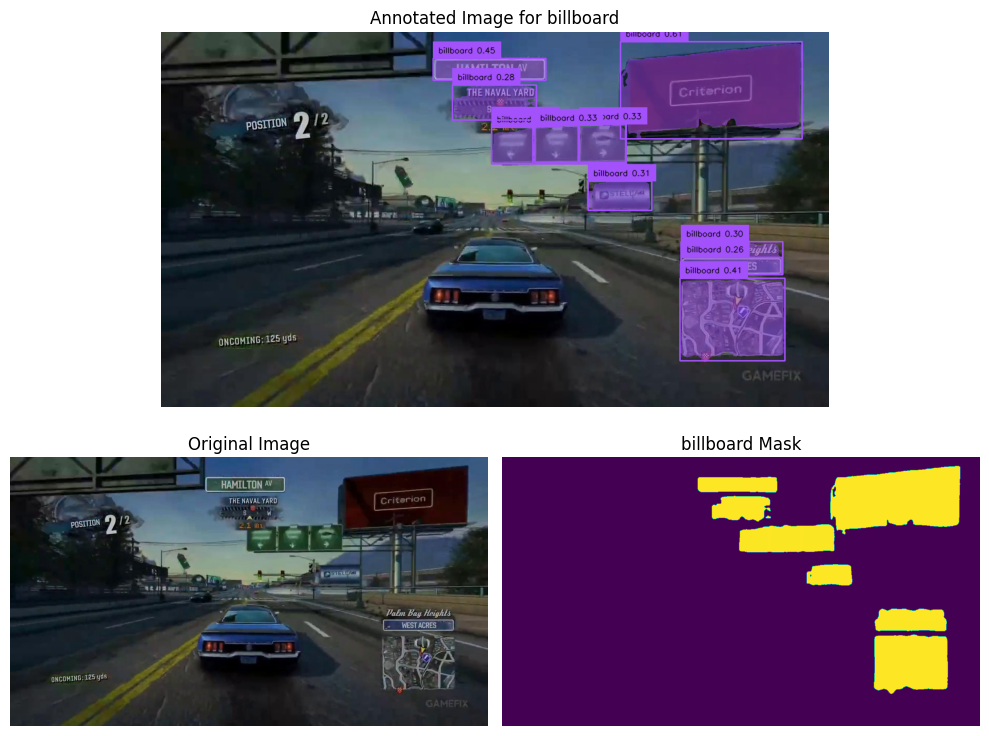

In [17]:
# @title Inference!
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

url = "/content/frame_0434.jpg" # @param {type:"string"}
query = "billboard" # @param {type:"string"}
an, im, mask = mask_image(url, query)

annotated_array = np.array(an)
original_array = np.array(im)
mask_array = np.array(mask)

# Create figure and a gridspec layout
fig = plt.figure(figsize=(10, 8))

# Define grid layout
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

# Annotated image across the first row, taking up both columns
ax0 = plt.subplot(gs[0, :])
ax0.imshow(annotated_array)
ax0.set_title(f"Annotated Image for {query}")
ax0.axis('off')

# Original image on the second row, first column
ax1 = plt.subplot(gs[1, 0])
ax1.imshow(original_array)
ax1.set_title("Original Image")
ax1.axis('off')

# Mask image on the second row, second column
ax2 = plt.subplot(gs[1, 1])
ax2.imshow(mask_array)
ax2.set_title(f"{query} Mask")
ax2.axis('off')

plt.tight_layout()
plt.show()


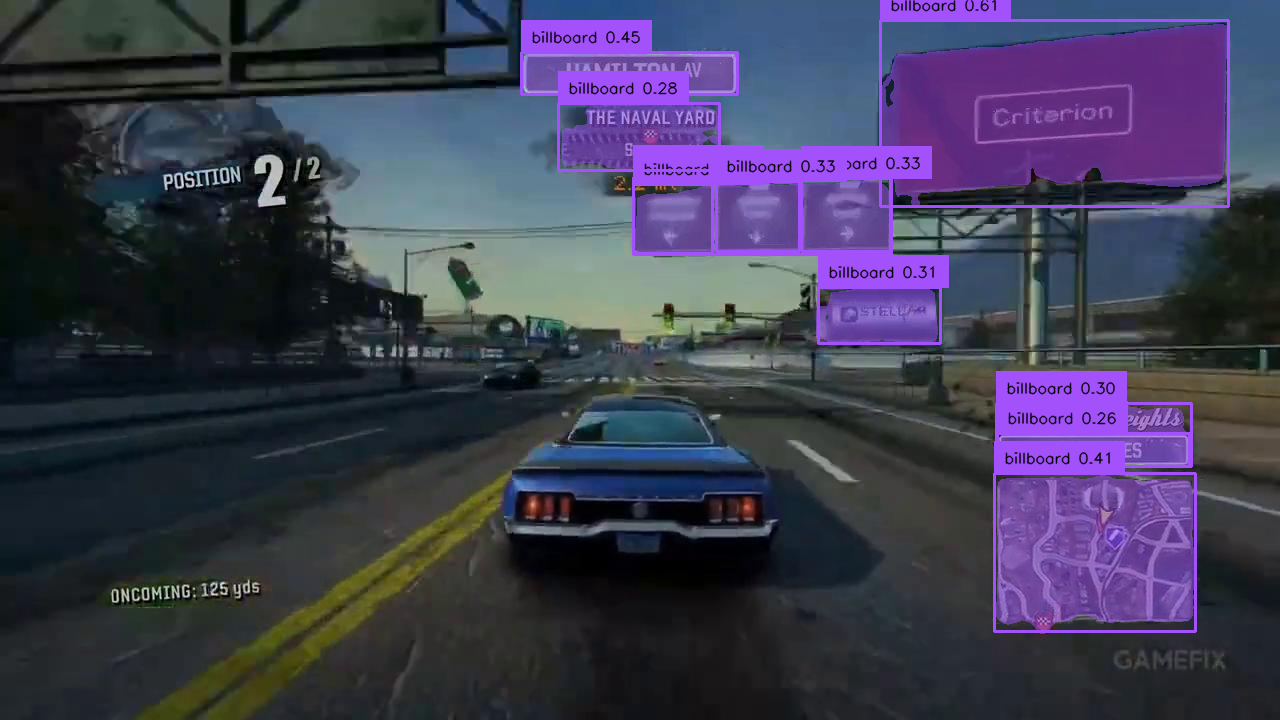

In [18]:
from google.colab.patches import cv2_imshow
an

In [7]:
import numpy as np
np_mask = np.array(mask)
np_mask.shape

(720, 1280)

In [8]:
import numpy as np

# Assuming `mask` is a binary array (non-zero values indicating the object)
# and np_mask has been already defined as np.array(mask) with shape (864, 1536)

# Find all non-zero (y, x) coordinates
y_indices, x_indices = np.nonzero(np_mask)

# Find extreme points
x_min, x_max = np.min(x_indices), np.max(x_indices)
y_min, y_max = np.min(y_indices), np.max(y_indices)

# Construct the bounding box's corners
# Top-Left, Top-Right, Bottom-Right, Bottom-Left
frame_corners = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]])

frame_corners


array([[  0,   0],
       [899,   0],
       [899, 263],
       [  0, 263]])

In [ ]:
# # import cv2
# from google.colab.patches import cv2_imshow
# # # Load your input image
# # # input_image = cv2.imread('path_to_your_image.jpg')

# # # Dummy input image for demonstration (replace this with actual image loading)
# # input_image = np.zeros((864, 1536, 3), dtype=np.uint8)

# # # Define the color and thickness of the lines
# color = (0, 255, 0)  # Green color in BGR
# thickness = 2  # Thickness of the lines
# input_image = np.array(im)
# # Draw lines between the corners
# cv2.line(input_image, tuple(frame_corners[0]), tuple(frame_corners[1]), color, thickness)
# cv2.line(input_image, tuple(frame_corners[1]), tuple(frame_corners[2]), color, thickness)
# cv2.line(input_image, tuple(frame_corners[2]), tuple(frame_corners[3]), color, thickness)
# cv2.line(input_image, tuple(frame_corners[3]), tuple(frame_corners[0]), color, thickness)

# # Display the image with the bounding box
# cv2_imshow(input_image)



In [9]:
cv2_imshow(np_mask)

NameError: name 'cv2_imshow' is not defined

27783.0
10252.0
5995.0
16881.0
56.5
8249.5
8131.5
49094.5


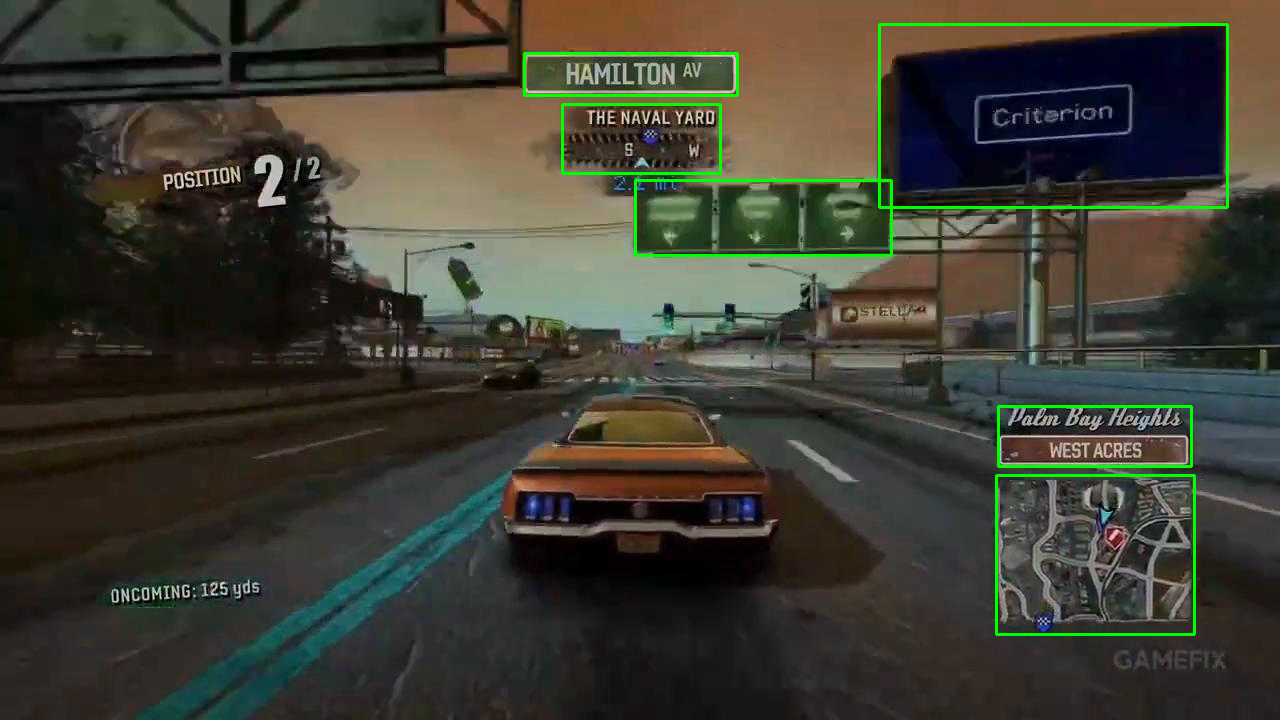

In [19]:
binary_image = np.array(mask)
image = np.array(im).copy()
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize a list to hold the frame corners for each instance
instances_frame_corners = []

area_threshold = 4500
# Loop through the contours to find the bounding box of each instance
for contour in contours:
    # Calculate the area of the contour
    area = cv2.contourArea(contour)
    print(area)

    # Filter contours by area
    if area > 7000:
        # Compute the bounding rectangle for a contour
        x, y, w, h = cv2.boundingRect(contour)

        # Calculate the corners of the bounding box
        frame_corners = np.array([
            [x, y],
            [x + w, y],
            [x + w, y + h],
            [x, y + h]
        ])

        # Draw the bounding box on the original image for visual verification
        cv2.drawContours(image, [frame_corners], -1, (0, 255, 0), 2)

        # Append to the list of frame corners
        instances_frame_corners.append(frame_corners)

# Convert image to BGR for displaying with cv2 (since the image is grayscale)
# image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Display the image with bounding boxes
cv2_imshow(image)

#polugon try

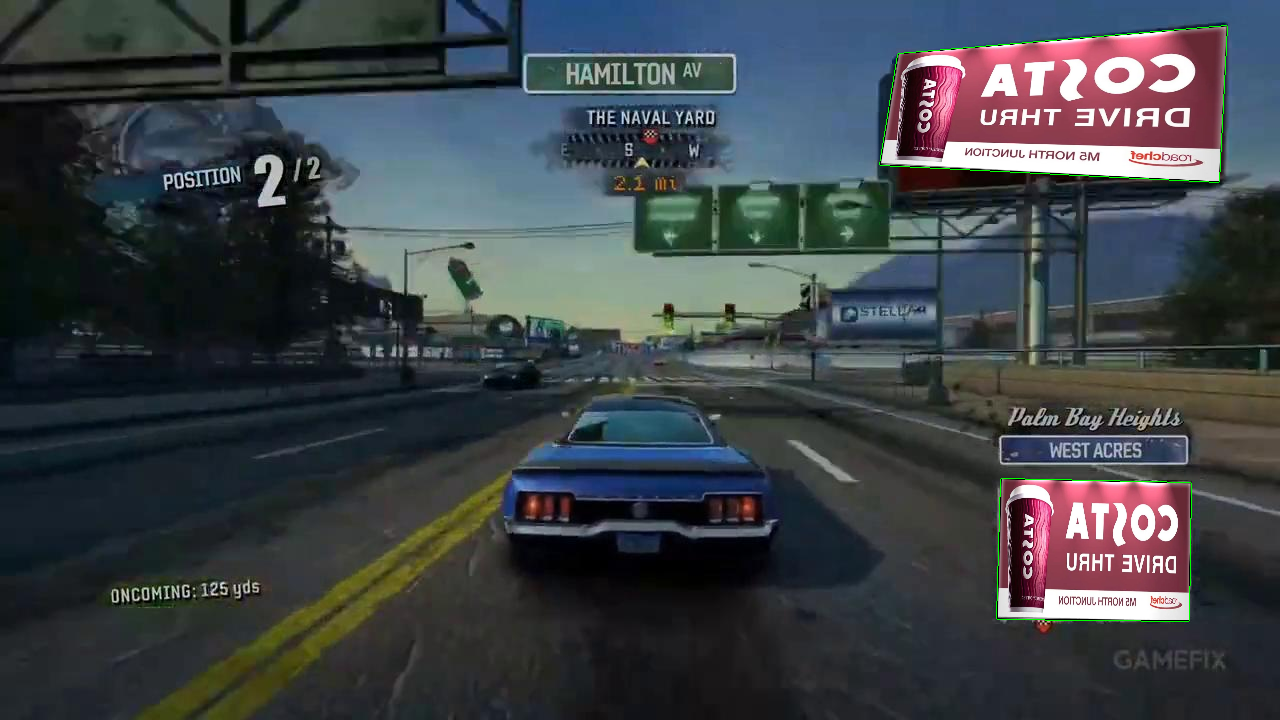

In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assume 'mask' is the numpy array representing the binary mask
# Assume 'im' is the numpy array representing the original image
binary_image = np.array(mask)
image = np.array(im).copy()

# Load your advertisement image (this should be done outside the loop)
ad_image = cv2.imread('/content/ad1.jpg')
ad_image = cv2.cvtColor(ad_image, cv2.COLOR_BGR2RGB)

# Find contours in the binary image
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize a list to hold the frame corners for each instance
frame_corners = []

# Define area threshold for filtering contours
area_threshold = 20000

# Loop through the contours to find the bounding polygon of each instance
for contour in contours:
    # Calculate the area of the contour
    area = cv2.contourArea(contour)

    # Filter contours by area, keeping only the ones larger than the threshold
    if area > area_threshold:
        # Approximate the contour to a polygon
        # epsilon = 0.02 * cv2.arcLength(contour, True)
        epsilon = 0.038 * cv2.arcLength(contour, True)
        polygon = cv2.approxPolyDP(contour, epsilon, True)

        # Draw the polygon on the original image for visual verification
        cv2.polylines(image, [polygon], True, (0, 255, 0), 2)

        # Append the polygon points to the list of frame corners
        # frame_corners.append(polygon)

        # Assuming ad_image_corners are the corners of the ad_image
        ad_image_corners = np.float32([[0, 0], [ad_image.shape[1], 0], [ad_image.shape[1], ad_image.shape[0]], [0, ad_image.shape[0]]])

        # PASTING
        frame_corners = polygon
        # Compute the perspective transform matrix
        transform_matrix = cv2.getPerspectiveTransform(ad_image_corners, frame_corners.astype(np.float32))

        # Warp the ad image to match the target space defined by frame_corners
        warped_ad_image = cv2.warpPerspective(ad_image, transform_matrix, (image.shape[1], image.shape[0]))

        # Create a mask from the warped image for blending
        mask_ = np.zeros_like(image)
        cv2.fillConvexPoly(mask_, frame_corners.astype(np.int32), (255, 255, 255))
        warped_image_masked = cv2.bitwise_and(warped_ad_image, mask_)
        image_masked = cv2.bitwise_and(image, cv2.bitwise_not(mask_))
        image = cv2.add(image_masked, warped_image_masked)

# Since we're using Jupyter or similar environment, we use matplotlib to display the image
cv2_imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.title('Image with Detected Polygons')
# plt.axis('off')
# plt.show()


In [32]:
polygon.shape

(4, 1, 2)

# seamlessclone


27783.0
center:(1094, 550)
10252.0
5995.0
16881.0
56.5
8249.5
8131.5
49094.5
center:(1055, 106)


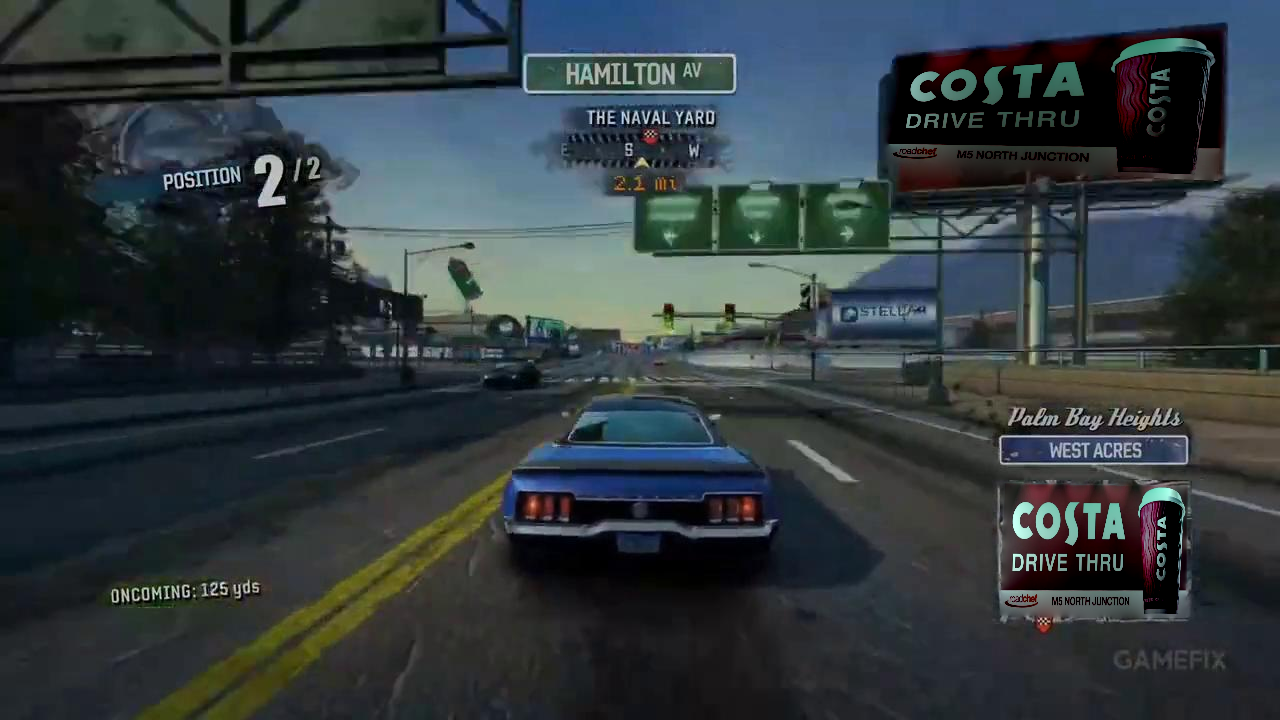

In [72]:
import cv2
import numpy as np

# Assume 'mask' is the numpy array representing the binary mask
# Assume 'im' is the numpy array representing the original image
binary_image = np.array(mask)
image = np.array(im).copy()

# Load your advertisement image
ad_image = cv2.imread('/content/ad1.jpg')
ad_image = cv2.cvtColor(ad_image, cv2.COLOR_BGR2RGB)
# Find contours in the binary image
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Define area threshold for filtering contours
area_threshold = 20000

# Loop through the contours to find the bounding polygon of each instance
for contour in contours:

    # Calculate the area of the contour
    area = cv2.contourArea(contour)
    print(area)

    # Filter contours by area, keeping only the ones larger than the threshold
    if area > area_threshold:
        # Approximate the contour to a polygon
        epsilon = 0.04 * cv2.arcLength(contour, True)
        polygon = cv2.approxPolyDP(contour, epsilon, True)

        # First, reshape your polygon array to a 2D array for easier manipulation
        poly = polygon.reshape(4, 2)

        # Then sort by y-coordinate
        poly = poly[np.argsort(poly[:, 1])]

        # Now, you have the top two points (first and second) and bottom two points (third and fourth)
        # Among the top two points, sort by x-coordinate to find top-left and top-right
        top_two = poly[:2]
        top_two = top_two[np.argsort(top_two[:, 0])]

        # Do the same for the bottom two points
        bottom_two = poly[2:]
        bottom_two = bottom_two[np.argsort(bottom_two[:, 0])]

        # Combine them back into the correctly ordered array
        polygon = np.vstack([top_two, bottom_two[::-1]]).astype(np.int32)

        # print(ordered_polygon)


        # Assuming ad_image_corners are the corners of the ad_image
        ad_image_corners = np.float32([[0, 0], [ad_image.shape[1], 0], [ad_image.shape[1], ad_image.shape[0]], [0, ad_image.shape[0]]])
        frame_corners = np.float32(polygon)

        # Compute the perspective transform matrix
        transform_matrix = cv2.getPerspectiveTransform(ad_image_corners, frame_corners)

        # Warp the ad image to match the target space defined by frame_corners
        warped_ad_image = cv2.warpPerspective(ad_image, transform_matrix, (image.shape[1], image.shape[0]))

        # Create a mask for the polygon to define the region for seamless cloning
        mask_ = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillConvexPoly(mask_, frame_corners.astype(np.int32), (255))

        # Find the center of the polygon to position the cloned region
        center = tuple(np.mean(frame_corners, axis=0).astype(np.int32))
        print(f"center:{center}")
        # center = (center[0][0], center[0][1])

        # Use seamless clone to blend the warped advertisement into the original image
        image = cv2.seamlessClone(warped_ad_image, image, mask_, center, cv2.NORMAL_CLONE)

# Display the result
cv2_imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# cv2_imshow(image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [68]:
import cv2
import numpy as np

# Assume 'mask' is the numpy array representing the binary mask
# Assume 'im' is the numpy array representing the original image
binary_image = np.array(mask)
image = np.array(im).copy()

# Load your advertisement image
ad_image = cv2.imread('/content/ad1.jpg')
ad_image = cv2.cvtColor(ad_image, cv2.COLOR_BGR2RGB)
# Find contours in the binary image
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Define area threshold for filtering contours
area_threshold = 20000

# Loop through the contours to find the bounding polygon of each instance
for contour in contours:

    # Calculate the area of the contour
    area = cv2.contourArea(contour)
    print(area)

    # Filter contours by area, keeping only the ones larger than the threshold
    if area > area_threshold:
        # Approximate the contour to a polygon
        epsilon = 0.04 * cv2.arcLength(contour, True)
        polygon = cv2.approxPolyDP(contour, epsilon, True)

        # First, reshape your polygon array to a 2D array for easier manipulation
        poly = polygon.reshape(4, 2)

        # Then sort by y-coordinate
        poly = poly[np.argsort(poly[:, 1])]

        # Now, you have the top two points (first and second) and bottom two points (third and fourth)
        # Among the top two points, sort by x-coordinate to find top-left and top-right
        top_two = poly[:2]
        top_two = top_two[np.argsort(top_two[:, 0])]

        # Do the same for the bottom two points
        bottom_two = poly[2:]
        bottom_two = bottom_two[np.argsort(bottom_two[:, 0])]

        # Combine them back into the correctly ordered array
        polygon = np.vstack([top_two, bottom_two[::-1]]).astype(np.int32)

        # print(ordered_polygon)


        # Assuming ad_image_corners are the corners of the ad_image
        ad_image_corners = np.float32([[0, 0], [ad_image.shape[1], 0], [ad_image.shape[1], ad_image.shape[0]], [0, ad_image.shape[0]]])
        frame_corners = np.float32(polygon)

        # Compute the perspective transform matrix
        transform_matrix = cv2.getPerspectiveTransform(ad_image_corners, frame_corners)

        # Warp the ad image to match the target space defined by frame_corners
        warped_ad_image = cv2.warpPerspective(ad_image, transform_matrix, (image.shape[1], image.shape[0]))

        # Create a mask for the polygon to define the region for seamless cloning
        mask_ = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillConvexPoly(mask_, frame_corners.astype(np.int32), (255))

        # Find the center of the polygon to position the cloned region
        center = tuple(np.mean(frame_corners, axis=0).astype(np.int32))
        print(f"center:{center}")
        # center = (center[0][0], center[0][1])

        # Use seamless clone to blend the warped advertisement into the original image
        image = cv2.seamlessClone(warped_ad_image, image, mask_, center, cv2.NORMAL_CLONE)

# Display the result
cv2_imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# cv2_imshow(image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


array([[[1226,   26]],

       [[ 898,   54]],

       [[ 880,  164]],

       [[1218,  181]]], dtype=int32)

#FINAL

21912.5
3545.0
3964.5
2008.0
2767.0
10380.5


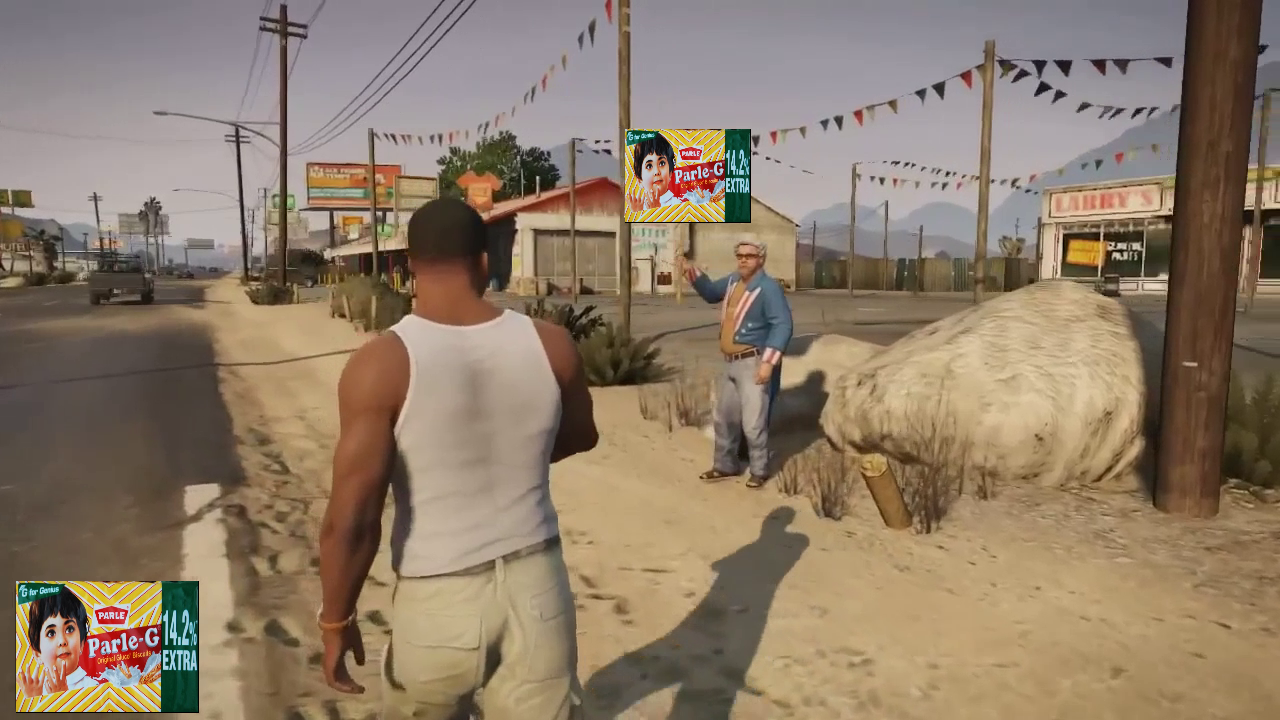

In [ ]:
import cv2
import numpy as np

# Assume 'mask' is the numpy array representing the binary mask
# Assume 'im' is the numpy array representing the original image
binary_image = np.array(mask)
image = np.array(im).copy()

# Load your advertisement image
ad_image = cv2.imread('/content/ad1.jpg')
ad_image = cv2.cvtColor(ad_image, cv2.COLOR_BGR2RGB)
# Find contours in the binary image
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Define area threshold for filtering contours
area_threshold = 20000

# Loop through the contours to find the bounding polygon of each instance
for contour in contours:

    # Calculate the area of the contour
    area = cv2.contourArea(contour)
    print(area)

    # Filter contours by area, keeping only the ones larger than the threshold
    if area > area_threshold:
        # Approximate the contour to a polygon
        epsilon = 0.04 * cv2.arcLength(contour, True)
        polygon = cv2.approxPolyDP(contour, epsilon, True)

        # First, reshape your polygon array to a 2D array for easier manipulation
        poly = polygon.reshape(4, 2)

        # Then sort by y-coordinate
        poly = poly[np.argsort(poly[:, 1])]

        # Now, you have the top two points (first and second) and bottom two points (third and fourth)
        # Among the top two points, sort by x-coordinate to find top-left and top-right
        top_two = poly[:2]
        top_two = top_two[np.argsort(top_two[:, 0])]

        # Do the same for the bottom two points
        bottom_two = poly[2:]
        bottom_two = bottom_two[np.argsort(bottom_two[:, 0])]

        # Combine them back into the correctly ordered array
        polygon = np.vstack([top_two, bottom_two[::-1]]).astype(np.int32)

        # print(ordered_polygon)


        # Assuming ad_image_corners are the corners of the ad_image
        ad_image_corners = np.float32([[0, 0], [ad_image.shape[1], 0], [ad_image.shape[1], ad_image.shape[0]], [0, ad_image.shape[0]]])
        frame_corners = np.float32(polygon)

        # Compute the perspective transform matrix
        transform_matrix = cv2.getPerspectiveTransform(ad_image_corners, frame_corners)

        # Warp the ad image to match the target space defined by frame_corners
        warped_ad_image = cv2.warpPerspective(ad_image, transform_matrix, (image.shape[1], image.shape[0]))

        # Create a mask for the polygon to define the region for seamless cloning
        mask_ = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillConvexPoly(mask_, frame_corners.astype(np.int32), (255))

        # Find the center of the polygon to position the cloned region
        center = tuple(np.mean(frame_corners, axis=0).astype(np.int32))
        print(f"center:{center}")
        # center = (center[0][0], center[0][1])

        # Use seamless clone to blend the warped advertisement into the original image
        image = cv2.seamlessClone(warped_ad_image, image, mask_, center, cv2.NORMAL_CLONE)

# Display the result
cv2_imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# cv2_imshow(image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


# VIDEO

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
/content/drive/london_hackathon

NameError: name 'content' is not defined

In [76]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!ls /content/drive/london_hackathon

ls: cannot access '/content/drive/london_hackathon': No such file or directory


In [116]:
import cv2
import numpy as np
from moviepy.editor import ImageSequenceClip
import os
from glob import glob
import shutil
source_directory = '/content/drive/MyDrive/london_hackathon/frames_3'
output_directory = '/content/drive/MyDrive/london_hackathon/modified_frames'
shutil.rmtree(output_directory)

os.makedirs(output_directory, exist_ok=True)

# Load your advertisement image
ad_image_path = '/content/ad1.jpg'
ad_image = cv2.imread(ad_image_path)
# ad_image = cv2.cvtColor(ad_image, cv2.COLOR_BGR2RGB)

# Define area threshold for filtering contours
area_threshold = 15000

# List to hold paths of modified frames
modified_frames = []

# Loop over all image frames in the source directory
for frame_path in sorted(glob(os.path.join(source_directory, '*.jpg'))):  # or *.png if your frames are in png format
    print(f"frame_path: {frame_path}")
    image = cv2.imread(frame_path)


    query = "rectangular billboard"
    an, im, mask = mask_image(frame_path, query)

    annotated_array = np.array(an)
    original_array = np.array(im)
    mask_array = np.array(mask)








    # binary_image = cv2.cvtColor(mask_array, cv2.COLOR_BGR2GRAY)  # Assuming the mask is already integrated within the frames
    binary_image = mask_array # Assuming the mask is already integrated within the frames

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Calculate the area of the contour
        area = cv2.contourArea(contour)
        # print(area)

        # Filter contours by area, keeping only the ones larger than the threshold
        if area > area_threshold:
            epsilon = 0.04 * cv2.arcLength(contour, True)
            polygon = cv2.approxPolyDP(contour, epsilon, True)
            polygon = filter(polygon)

            # if polygon == -1:
            #     print("nOt rectzngular !!!!!!!!!!!!!!")
            #     break

            # First, reshape your polygon array to a 2D array for easier manipulation
            poly = polygon.reshape(4, 2)

            # Then sort by y-coordinate
            poly = poly[np.argsort(poly[:, 1])]

            # Now, you have the top two points (first and second) and bottom two points (third and fourth)
            # Among the top two points, sort by x-coordinate to find top-left and top-right
            top_two = poly[:2]
            top_two = top_two[np.argsort(top_two[:, 0])]

            # Do the same for the bottom two points
            bottom_two = poly[2:]
            bottom_two = bottom_two[np.argsort(bottom_two[:, 0])]

            # Combine them back into the correctly ordered array
            polygon = np.vstack([top_two, bottom_two[::-1]]).astype(np.int32)

            # print(ordered_polygon)


            # Assuming ad_image_corners are the corners of the ad_image
            ad_image_corners = np.float32([[0, 0], [ad_image.shape[1], 0], [ad_image.shape[1], ad_image.shape[0]], [0, ad_image.shape[0]]])
            frame_corners = np.float32(polygon)

            # Compute the perspective transform matrix
            transform_matrix = cv2.getPerspectiveTransform(ad_image_corners, frame_corners)

            # Warp the ad image to match the target space defined by frame_corners
            warped_ad_image = cv2.warpPerspective(ad_image, transform_matrix, (image.shape[1], image.shape[0]))

            # Create a mask for the polygon to define the region for seamless cloning
            mask_ = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
            cv2.fillConvexPoly(mask_, frame_corners.astype(np.int32), (255))

            # Find the center of the polygon to position the cloned region
            center = tuple(np.mean(frame_corners, axis=0).astype(np.int32))
            print(f"center:{center}")
            # center = (center[0][0], center[0][1])

            # Use seamless clone to blend the warped advertisement into the original image
            try:
                image = cv2.seamlessClone(warped_ad_image, image, mask_, center, cv2.NORMAL_CLONE)
            except:
                pass
    # Save the modified frame to the output directory
    output_frame_path = os.path.join(output_directory, os.path.basename(frame_path))

    # #DEBUG
    # cv2_imshow(image)
    # break

    # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_frame_path, image)
    modified_frames.append(output_frame_path)

# Stitch the video using MoviePy
clip = ImageSequenceClip(modified_frames, fps=24)  # Replace with the actual FPS of your video
video_path = '/content/drive/MyDrive/london_hackathon/output_video_3.mp4'
clip.write_videofile(video_path)

# Cleanup: remove the temporary modified frames if desired
for frame_path in modified_frames:
    os.remove(frame_path)

print(f"Video saved to {video_path}")


frame_path: /content/drive/MyDrive/london_hackathon/frames_2/frame_0500.jpg
center:(824, 196)
frame_path: /content/drive/MyDrive/london_hackathon/frames_2/frame_0501.jpg
center:(828, 194)
frame_path: /content/drive/MyDrive/london_hackathon/frames_2/frame_0502.jpg
center:(832, 192)
frame_path: /content/drive/MyDrive/london_hackathon/frames_2/frame_0503.jpg
center:(835, 191)
frame_path: /content/drive/MyDrive/london_hackathon/frames_2/frame_0504.jpg
center:(840, 189)
frame_path: /content/drive/MyDrive/london_hackathon/frames_2/frame_0505.jpg
center:(844, 186)
frame_path: /content/drive/MyDrive/london_hackathon/frames_2/frame_0506.jpg
center:(850, 185)
frame_path: /content/drive/MyDrive/london_hackathon/frames_2/frame_0507.jpg
center:(857, 181)
frame_path: /content/drive/MyDrive/london_hackathon/frames_2/frame_0508.jpg
center:(860, 181)
frame_path: /content/drive/MyDrive/london_hackathon/frames_2/frame_0509.jpg
center:(866, 178)
frame_path: /content/drive/MyDrive/london_hackathon/frames_2

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/london_hackathon/output_video_1.mp4
Video saved to /content/drive/MyDrive/london_hackathon/output_video_1.mp4


In [93]:
polygon

array([[[1009,  480]],

       [[1042,  633]],

       [[1047,  575]],

       [[1188,  617]],

       [[1187,  481]],

       [[1061,  525]]], dtype=int32)

In [110]:
import cv2
import numpy as np


def filter (polygon):
    # Example contour with more than four points
    contour = polygon

    # Reshape for processing
    contour = contour.reshape((-1, 2))

    # Calculate the centroid of the polygon
    centroid = np.mean(contour, axis=0)

    # Calculate the angles of each point with the centroid
    angles = np.arctan2(contour[:, 1] - centroid[1], contour[:, 0] - centroid[0])

    # Sort the points based on the angles
    sorted_points = contour[np.argsort(angles)]

    # Select the four points that form the extreme angles
    corner_points = np.array([
        sorted_points[0],   # Top-left point
        sorted_points[-2],  # Top-right point
        sorted_points[-1],  # Bottom-right point
        sorted_points[1]    # Bottom-left point
    ])

    # Ensure the points are in the correct order (top-left, top-right, bottom-right, bottom-left)
    corner_points = np.array([
        corner_points[np.argmin(corner_points[:, 0] + corner_points[:, 1])],  # Top-left point
        corner_points[np.argmax(corner_points[:, 0] - corner_points[:, 1])],  # Top-right point
        corner_points[np.argmax(corner_points[:, 0] + corner_points[:, 1])],  # Bottom-right point
        corner_points[np.argmin(corner_points[:, 0] - corner_points[:, 1])]   # Bottom-left point
    ])

    # Print out the selected points
    return (corner_points)


In [105]:
# import cv2
# import numpy as np

# def is_approx_rectangular(points, threshold_angle=10):
#     # This function checks if the angles between vectors formed by adjacent points are close to 90 degrees.
#     # Points need to be in order: top-left, top-right, bottom-right, bottom-left
#     vectors = np.diff(points, axis=0, append=points[:1])
#     angles = []

#     for i in range(len(vectors)):
#         vec1 = vectors[i]
#         vec2 = vectors[(i + 1) % len(vectors)]
#         dot_product = np.dot(vec1, vec2)
#         norm_product = np.linalg.norm(vec1) * np.linalg.norm(vec2)
#         angle = np.degrees(np.arccos(dot_product / norm_product))
#         angles.append(angle)

#     # Check if all angles are close to 90 degrees within a threshold
#     return all(np.abs(angle - 90) <= threshold_angle for angle in angles)

# def filter(polygon):
#     # Reshape for processing
#     contour = polygon.reshape((-1, 2))

#     # Calculate the centroid of the polygon
#     centroid = np.mean(contour, axis=0)

#     # Calculate the angles of each point with the centroid
#     angles = np.arctan2(contour[:, 1] - centroid[1], contour[:, 0] - centroid[0])

#     # Sort the points based on the angles
#     sorted_points = contour[np.argsort(angles)]

#     # Select the four points that form the extreme angles
#     corner_points = np.array([
#         sorted_points[0],   # Top-left point
#         sorted_points[-2],  # Top-right point
#         sorted_points[-1],  # Bottom-right point
#         sorted_points[1]    # Bottom-left point
#     ])

#     # Order the points correctly
#     corner_points_ordered = np.array([
#         corner_points[np.argmin(corner_points[:, 0] + corner_points[:, 1])],  # Top-left
#         corner_points[np.argmax(corner_points[:, 0] - corner_points[:, 1])],  # Top-right
#         corner_points[np.argmax(corner_points[:, 0] + corner_points[:, 1])],  # Bottom-right
#         corner_points[np.argmin(corner_points[:, 0] - corner_points[:, 1])]   # Bottom-left
#     ])

#     # Check if the ordered points form an approximately rectangular shape
#     if is_approx_rectangular(corner_points_ordered):
#         return corner_points_ordered
#     else:
#         return -1

# # Example usage:
# polygon = np.array([[[1009,  480]],
#                     [[1042,  633]],
#                     [[1047,  575]],
#                     [[1188,  617]],
#                     [[1187,  481]],
#                     [[1061,  525]]], dtype=np.int32)

# filtered_corners = filter(polygon)
# print(filtered_corners)


  angle = np.degrees(np.arccos(dot_product / norm_product))



-1
